In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error


Reading the data using pandas

In [2]:
df = pd.read_csv('Datafromfloors.csv')

Sanity checks of the read

In [3]:
#Working on only one floor for the time being
third_floor_gymnasium = df.loc[df['Location']=='Marino Center - 3rd Floor Weight Room']
#Dropping the redundant column Location
third_floor_gymnasium = third_floor_gymnasium.drop(columns=['Location'])
#While converting the data by hand, an artificial empty column was introduced as an artifact in the data, removing it.
third_floor_gymnasium = third_floor_gymnasium.iloc[:,:-1]
third_floor_gymnasium.head(10)

,Date,5:00 AM,6:00 AM,7:00 AM,8:00 AM,9:00 AM,10:00 AM,11:00 AM,12:00 PM,1:00 PM,...,3:00 PM,4:00 PM,5:00 PM,6:00 PM,7:00 PM,8:00 PM,9:00 PM,10:00 PM,11:00 PM,Total Count
5,1/9/2023 0:00,11.0,42.0,39.0,43.0,48,38.0,48,50.0,44,...,54,62.0,75.0,63.0,67.0,51.0,54.0,56.0,50.0,942
12,1/10/2023 0:00,14.0,31.0,29.0,45.0,47,61.0,52,52.0,45,...,60,63.0,56.0,43.0,58.0,46.0,50.0,40.0,NaN,843
19,1/11/2023 0:00,NaN,24.0,41.0,54.0,53,52.0,53,63.0,39,...,54,58.0,66.0,66.0,54.0,44.0,61.0,60.0,NaN,875
26,1/12/2023 0:00,15.0,28.0,27.0,38.0,40,39.0,44,50.0,37,...,73,65.0,61.0,87.0,68.0,54.0,50.0,49.0,NaN,893
33,1/13/2023 0:00,18.0,23.0,22.0,23.0,27,29.0,39,57.0,38,...,40,76.0,63.0,65.0,49.0,51.0,41.0,17.0,NaN,715
40,1/14/2023 0:00,NaN,NaN,NaN,22.0,29,28.0,32,30.0,36,...,39,NaN,NaN,39.0,36.0,28.0,26.0,25.0,17.0,425
47,1/15/2023 0:00,NaN,NaN,NaN,15.0,31,37.0,37,37.0,46,...,40,41.0,37.0,42.0,57.0,38.0,32.0,30.0,19.0,587
54,1/16/2023 0:00,6.0,17.0,15.0,24.0,40,43.0,59,68.0,71,...,47,63.0,55.0,60.0,48.0,54.0,49.0,47.0,40.0,852
61,1/17/2023 0:00,2.0,27.0,30.0,43.0,36,56.0,64,54.0,50,...,65,75.0,69.0,76.0,58.0,58.0,68.0,60.0,NaN,953
68,1/18/2023 0:00,19.0,38.0,48.0,36.0,48,42.0,56,71.0,45,...,67,67.0,65.0,67.0,52.0,56.0,49.0,54.0,NaN,919


In [4]:
#Excluding the date column and total count
columns_to_melt = third_floor_gymnasium.columns[1:-1]

#Dropping total count for the day
df3 = third_floor_gymnasium.drop('Total Count',axis=1)

#Changing the format from a table to logs of tuples
melted_df = pd.melt(
    df3,
    id_vars='Date',
    value_vars=columns_to_melt,
    var_name='time',
    value_name='count'
)

# Concatenate the date and time columns
melted_df["date time"] = melted_df["Date"] + " " + melted_df["time"]


# Drop the original date and time columns
melted_df.drop(["Date", "time"], axis=1, inplace=True)

#Convert the format of date time to datetime
melted_df['date time']=pd.to_datetime(melted_df['date time'])

# Sort by date time
melted_df.sort_values("date time", inplace=True)

# Reset index
melted_df.reset_index(drop=True, inplace=True)

# Output the resulting DataFrame
print(melted_df)


     count           date time
0     11.0 2023-01-09 05:00:00
1     42.0 2023-01-09 06:00:00
2     39.0 2023-01-09 07:00:00
3     43.0 2023-01-09 08:00:00
4     48.0 2023-01-09 09:00:00
..     ...                 ...
660   16.0 2023-02-12 19:00:00
661   17.0 2023-02-12 20:00:00
662   18.0 2023-02-12 21:00:00
663   21.0 2023-02-12 22:00:00
664    NaN 2023-02-12 23:00:00

[665 rows x 2 columns]


In [5]:
#Changing the index to date time
final_df = melted_df.set_index('date time')


In [6]:
#Resampling based on the mean
resampled_df = final_df.resample('5T').mean()

In [7]:
resampled_df = resampled_df.interpolate()

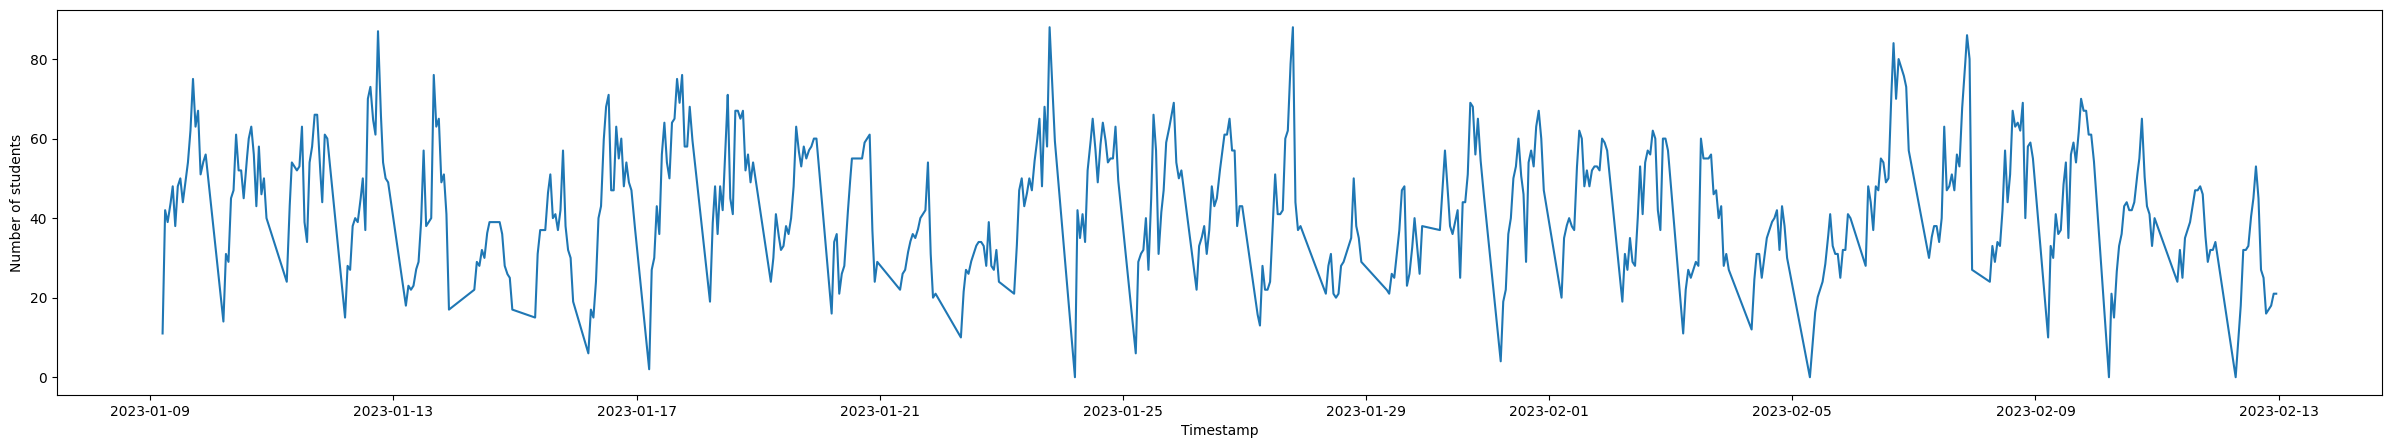

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,5))
plt.plot(resampled_df['count'])
plt.xlabel('Timestamp')
plt.ylabel('Number of students')
plt.show()

In [9]:

# split the dataframe into training and testing sets
train_size = 0.8 # set the ratio of training set
split_index = int(len(resampled_df) * train_size)
train_data = resampled_df.iloc[:split_index]
test_data = resampled_df.iloc[split_index:]

In [11]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(train_data)

ADF Statistic: -6.346487
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


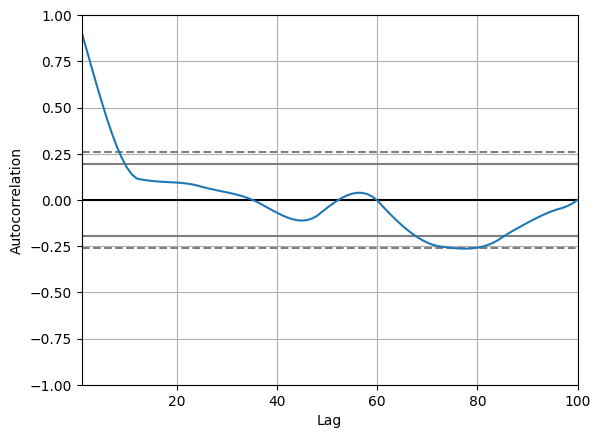

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train_data[:100])
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                 8007
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1668.279
Date:                Mon, 24 Apr 2023   AIC                           3348.557
Time:                        11:58:52   BIC                           3390.485
Sample:                    01-09-2023   HQIC                          3362.908
                         - 02-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9480      0.039     24.268      0.000       0.871       1.025
ar.L2      -2.221e-06      0.057   -3.9e-05      1.000      -0.111       0.111
ar.L3      -3.959e-06      0.057  -6.96e-05      1.0

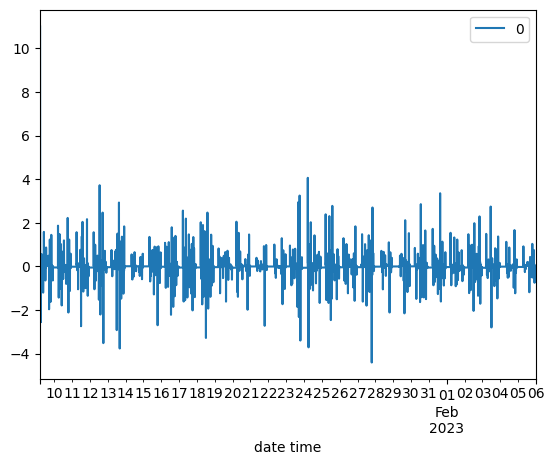

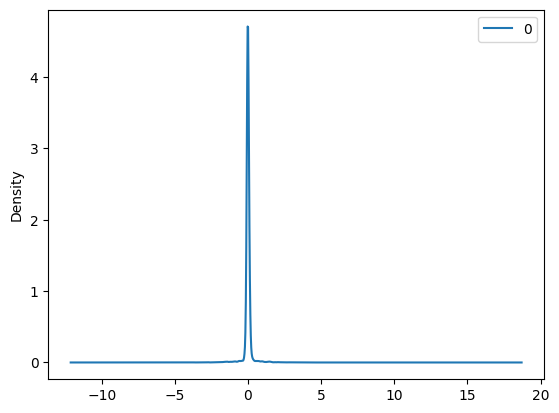

                 0
count  8007.000000
mean      0.001761
std       0.323434
min      -4.412731
25%      -0.043635
50%      -0.004786
75%       0.034908
max      11.000000


In [12]:
from statsmodels.tsa.arima.model import ARIMA
train_data.index = train_data.index.to_period('M')
# fit model
model = ARIMA(train_data, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [13]:
from tqdm import tqdm
history = [x for x in train_data.values]
# print(history)
predictions = []
for t in tqdm(range(len(test_data))):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test_data.iloc[t]    
 history.append(obs)
#  print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes

100%|██████████| 2002/2002 [33:28<00:00,  1.00s/it]

Test RMSE: 0.308


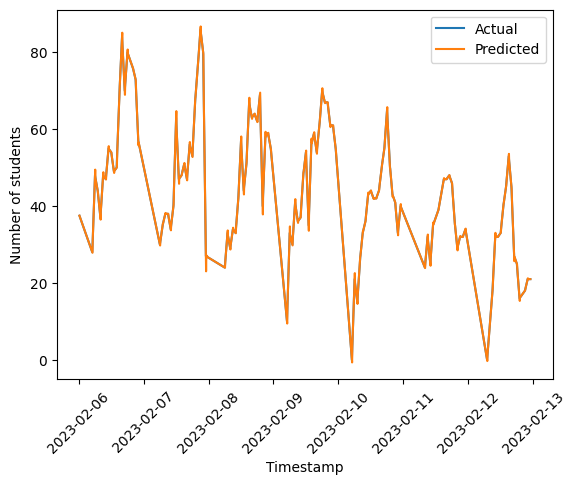

In [16]:
plt.plot(test_data.index, test_data['count'], label='Actual')
plt.plot(test_data.index, predictions, label='Predicted')
plt.xticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('Number of students')
plt.legend()
plt.show()

In [270]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data['count'], order=(5,1,0), seasonal_order=(1,0,0,7),trend='c')
result = model.fit()


In [271]:
ind = 2002-1443
predictions = result.predict(start=test_data.index[0], end=test_data.index[-ind])

In [272]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
test_data_batch = test_data.iloc[0:-ind]
mse = mean_squared_error(test_data_batch, predictions)
rmse = mean_squared_error(test_data_batch, predictions, squared=False)
mae = mean_absolute_error(test_data_batch, predictions)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MSE: 251.46
RMSE: 15.86
MAE: 12.93


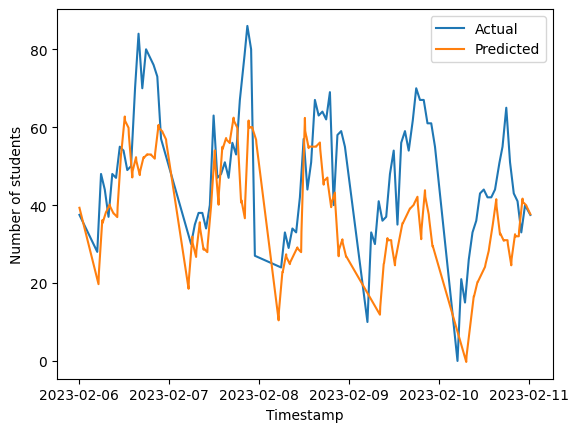

In [273]:
plt.plot(test_data_batch.index, test_data_batch['count'], label='Actual')
plt.plot(test_data_batch.index, predictions, label='Predicted')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.ylabel('Number of students')
plt.legend()
plt.show()

In [25]:
model = ARIMA(train_data, order=(5,1,0), seasonal_order=(1,0,0,7))
result = model.fit()
predictions = result.predict(start=test_data.index[0], end=test_data.index[-2])
from sklearn.metrics import mean_squared_error, mean_absolute_error
test_data_batch = test_data.iloc[0:-1]
mse = mean_squared_error(test_data_batch, predictions)
rmse = mean_squared_error(test_data_batch, predictions, squared=False)
mae = mean_absolute_error(test_data_batch, predictions)

print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MSE: 297.51
RMSE: 17.25
MAE: 13.46


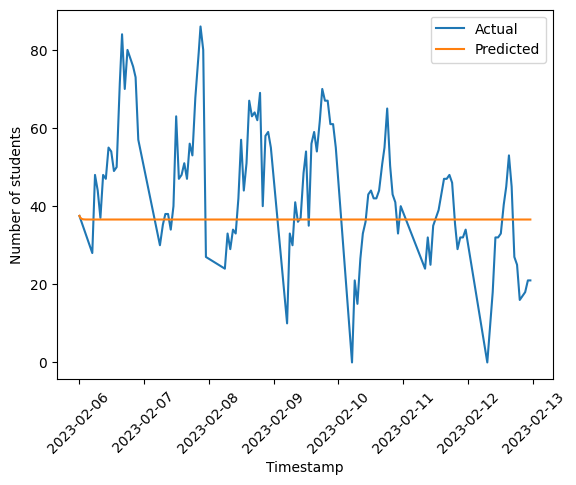

In [26]:
plt.plot(test_data_batch.index, test_data_batch['count'], label='Actual')
plt.plot(test_data_batch.index, predictions, label='Predicted')

plt.xlabel('Timestamp')
plt.xticks(rotation=45)
plt.ylabel('Number of students')
plt.legend()
plt.show()

In [29]:
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
def cross_validate_arima(data, p_range, d_range, q_range):
    # Define the number of folds
    n_splits = 5

    # Initialize the TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize an empty list to store the MSE of each model
    mse_list = []

    # Loop over the folds
    for train_index, test_index in tscv.split(data):
        # Split the data into training and testing sets for this fold
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Fit the ARIMA model to the training data
        arima_model = auto_arima(train_data, start_p=p_range[0], max_p=p_range[1],
                                 start_d=d_range[0], max_d=d_range[1],
                                 start_q=q_range[0], max_q=q_range[1], suppress_warnings=True,
                                 error_action='ignore', trace=False)
        arima_model.fit(train_data)

        # Make predictions on the testing data
        predictions = arima_model.predict(len(test_data))

        # Calculate the MSE of the predictions
        mse = ((predictions - test_data.values) ** 2).mean()

        # Add the MSE to the list of MSEs
        mse_list.append(mse)

    # Return the mean MSE of all the models
    return sum(mse_list) / len(mse_list)

In [30]:
# Specify the ranges for p, d, and q
p_range = (1, 3)
d_range = (1, 1)
q_range = (1, 3)

# Cross-fold validate the ARIMA model
mse = cross_validate_arima(train_data, p_range, d_range, q_range)

# Print the mean squared error
print('Mean squared error: {:.2f}'.format(mse))

ValueError: Data must be 1-dimensional